In [1]:
import os

VERSION = '20'
INPUT_DIR = 'data/'
VERSION_DIR = INPUT_DIR + VERSION + '/'
os.makedirs(VERSION_DIR, exist_ok=True)

print(VERSION_DIR)

data/20/


In [2]:
import polars as pl
import pandas as pd
import numpy as np
import math
import gc
from tqdm import tqdm
from math import pi
import pickle
import random
import datetime
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

%load_ext memory_profiler

In [3]:
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary

DEVICE = 'cuda:0'

assert torch.cuda.device_count() > 0
for i in range(torch.cuda.device_count()):
   print(i, '//', torch.cuda.get_device_properties(i).name)

0 // NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
SEED = 0

def seed_all(seed: int) -> None:
    """
    Seed current experiment to guarantee reproducibility.

    Parameters:
        seed: manually specified seed number

    Return:
        None
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running with cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_all(SEED)

In [5]:
from scipy.signal import find_peaks

from GRUNet9 import Net
from utils import pkl_save, pkl_load, train_valid_split
from metrics import event_detection_ap

In [6]:
series_ids = pkl_load(VERSION_DIR, 'series_ids')
Xs = pkl_load(VERSION_DIR, 'Xs')
ys = pkl_load(VERSION_DIR, 'ys')
masks = pkl_load(VERSION_DIR, 'masks')
steps = pkl_load(VERSION_DIR, 'steps')

series_ids.pkl // FILE SIZE: 0 MB
Xs.pkl // FILE SIZE: 3195 MB
ys.pkl // FILE SIZE: 82 MB
masks.pkl // FILE SIZE: 82 MB
steps.pkl // FILE SIZE: 82 MB


0  //  243  //  26
1  //  242  //  27
2  //  242  //  27
3  //  242  //  27
4  //  242  //  27
5  //  242  //  27
6  //  242  //  27
7  //  242  //  27
8  //  242  //  27
9  //  242  //  27
Learning Rate From 0.001 to 1e-05


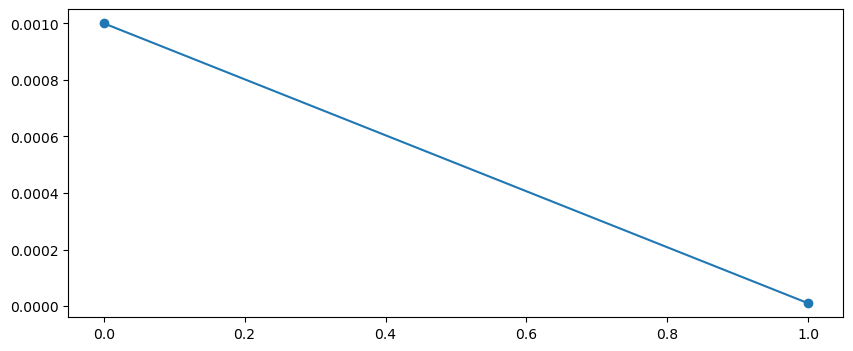

In [7]:
N_FOLDS = 10
WEIGHT_DECAY = 0.001
EPOCHS = 2
BATCH_SIZE = 16
PATCH_SIZE = 12
D_MODEL = 64
N_FEATURES = 3
N_OUTPUTS = 1

train_ids, valid_ids = train_valid_split(series_ids, N_FOLDS)

LR_MAX = 0.001
LR_MIN = 0.00001
e = list(range(EPOCHS))
LR = []
for epoch in e:
    lr_decay = (math.cos((epoch/(EPOCHS-1)) * math.pi) + 1) * 0.5
    LR.append(LR_MIN + (LR_MAX - LR_MIN) * lr_decay)
print(f'Learning Rate From {LR_MAX} to {LR_MIN}')
plt.figure(figsize=(10, 4))
plt.plot(e, LR, '-o')

In [8]:
class DataGenerator():
    def __init__(self, Xs, ys, masks):
        self.Xs = torch.from_numpy(Xs)
        if ys is not None:
            self.ys = torch.from_numpy(ys)
        self.masks = torch.from_numpy(masks)
        self.checkdtype()

    def checkdtype(self):
        if 'ys' in dir(self):
            assert self.ys.dtype == torch.float32
        assert self.Xs.dtype == torch.float32
        assert self.masks.dtype == torch.float32
    
    def __len__(self):

        return len(self.Xs)
    
    def __getitem__(self, index):
        
        if 'ys' in dir(self):
            return self.Xs[index], self.ys[index], self.masks[index]
        else:
            return self.Xs[index], self.masks[index]

In [9]:
def train_one_epoch(
    model, 
    dataloader, 
    loss_fn, 
    optimizer, 
    scaler, 
    t0,
    device,
):
    
    model.train()
    torch.set_grad_enabled(True)
    len_loader = len(dataloader)
    losses = []
    
    for batch_idx, (x_batch, y_batch, mask_batch) in enumerate(dataloader, 1):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)
        
        ### Forward pass ###
        with autocast():
            preds = model(x_batch) * mask_batch
        loss = loss_fn(preds, y_batch)
        losses.extend([loss.item()] * len(x_batch))
            
        ### Backward pass ###
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        scaler.step(optimizer)
        scaler.update()

        ### Logging ###
        if batch_idx % (len_loader // 5) == 0 or batch_idx == len_loader:
            batch_loss = sum(losses) / len(losses)
            dt = int(time() - t0)
            hour = dt // 3600
            minute = dt // 60 % 60
            second = dt % 60
            lr = optimizer.param_groups[0]['lr']
            print(
                f"{f'{hour:02d}:{minute:02d}:{second:02d}' :^10} | "
                f"{f'{lr: .5f}' :^8} | "
                f"{f'{batch_idx} / {len_loader}' :^13} | "
                f'{batch_loss :^10.4f}'
            )
            
    del x_batch, y_batch, mask_batch, preds, loss
    gc.collect()
    torch.cuda.empty_cache()

def valid_one_epoch(
    model, 
    dataloader, 
    loss_fn, 
    t0,
    device,
):
    
    model.eval()
    torch.set_grad_enabled(False)
    len_loader = len(dataloader)
    losses = []
    
    for batch_idx, (x_batch, y_batch, mask_batch) in enumerate(dataloader, 1):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)
        
        ### Forward pass ###
        with autocast():
            preds = model(x_batch) * mask_batch
        loss = loss_fn(preds, y_batch)
        losses.extend([loss.item()] * len(x_batch))

        ### Logging ###
        if batch_idx == len_loader:
            batch_loss = sum(losses) / len(losses)
            dt = int(time() - t0)
            hour = dt // 3600
            minute = dt // 60 % 60
            second = dt % 60
            lr = optimizer.param_groups[0]['lr']
            print(
                f"{f'{hour:02d}:{minute:02d}:{second:02d}' :^10} | "
                f"{'valid' :^8} | "
                f"{f'{batch_idx} / {len_loader}' :^13} | "
                f'{batch_loss :^10.4f}'
            )
            
    del x_batch, y_batch, mask_batch, preds, loss
    gc.collect()
    torch.cuda.empty_cache()

    return batch_loss

def predict(model, dataloader, device):

    model.eval()
    torch.set_grad_enabled(False)
    len_loader = len(dataloader)
    predss = []
    
    for batch_idx, (x_batch, y_batch, mask_batch) in enumerate(dataloader, 1):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)
        
        ### Forward pass ###
        with autocast():
            preds = (model(x_batch) * mask_batch).detach().to('cpu').numpy()
        predss.append(preds)

    predss = np.concatenate(predss)

    del x_batch, y_batch, mask_batch, preds
    gc.collect()
    torch.cuda.empty_cache()
        
    return predss

In [10]:
%%time
%%memit

valid_preds = np.zeros_like(ys)
ss = {}

for fold in range(N_FOLDS):
    
    print()
    print(f'Fold: {fold} / {N_FOLDS}')
    print()
    print(
        f"{'Time': ^10} | "
        f"{'lr': ^8} | "
        f"{'Batch/Batches': ^13} | "
        f"{'Loss': ^10}"
    )
    model = Net(
        patch_size = PATCH_SIZE,
        n_features = N_FEATURES,
        d_model = D_MODEL,
        n_outputs = N_OUTPUTS
    )
    model.to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=WEIGHT_DECAY)
    scaler = GradScaler()
    t0 = time()
    train_indices = steps.index[steps['series_id'].isin(train_ids[fold])].tolist()
    train_ds = DataGenerator(Xs[train_indices], ys[train_indices], masks[train_indices])
    train_dl = DataLoader(
        dataset=train_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        pin_memory=True,
        drop_last=True,
    )    
    valid_indices = steps.index[steps['series_id'].isin(valid_ids[fold])].tolist()
    valid_ds = DataGenerator(Xs[valid_indices], ys[valid_indices], masks[valid_indices])
    valid_dl = DataLoader(
        dataset=valid_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        pin_memory=True,
        drop_last=False,
    )
    ss[fold] = []
    best_loss = 1
    best_epoch = 0
    for epoch in range(EPOCHS):
        print()
        print(f'Epoch: {epoch} / {EPOCHS}')
        optimizer.param_groups[0]['lr'] = LR[epoch]
        train_one_epoch(model, train_dl, loss_fn, optimizer, scaler, t0, DEVICE)
        loss = valid_one_epoch(model, valid_dl, loss_fn, t0, DEVICE)
        ss[fold].append(loss)
        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch
            torch.save(model.state_dict(), VERSION_DIR + f'model_f{fold}_e{best_epoch}.pt')
            print('model checkpoint')
        print(f'Best Epoch: {best_epoch} / {EPOCHS}')
        print()
        
    model.load_state_dict(
        torch.load(VERSION_DIR + f'model_f{fold}_e{best_epoch}.pt', map_location=DEVICE)
    )
    valid_preds[valid_indices] = predict(model, valid_dl, DEVICE)
    
    if fold == N_FOLDS-1:
        print(
            summary(
                model=model,
                input_size=(BATCH_SIZE, train_ds.Xs.shape[1], train_ds.Xs.shape[2]),
                col_names=["input_size", "output_size", "num_params"],
                col_width=20
            )
        )
    
    del model, loss_fn, optimizer, scaler, t0, train_indices, train_ds, train_dl, valid_indices, valid_ds, valid_dl
    gc.collect()
    torch.cuda.empty_cache()


Fold: 0 / 10

   Time    |    lr    | Batch/Batches |    Loss   

Epoch: 0 / 2
 00:00:19  |  0.00100 |   167 / 837   |   0.0054  
 00:00:36  |  0.00100 |   334 / 837   |   0.0046  
 00:00:54  |  0.00100 |   501 / 837   |   0.0042  
 00:01:11  |  0.00100 |   668 / 837   |   0.0040  
 00:01:29  |  0.00100 |   835 / 837   |   0.0038  
 00:01:29  |  0.00100 |   837 / 837   |   0.0038  
 00:01:32  |  valid   |    95 / 95    |   0.0035  
model checkpoint
Best Epoch: 0 / 2


Epoch: 1 / 2
 00:01:50  |  0.00001 |   167 / 837   |   0.0031  
 00:02:07  |  0.00001 |   334 / 837   |   0.0030  
 00:02:25  |  0.00001 |   501 / 837   |   0.0030  
 00:02:42  |  0.00001 |   668 / 837   |   0.0030  
 00:02:59  |  0.00001 |   835 / 837   |   0.0030  
 00:03:00  |  0.00001 |   837 / 837   |   0.0030  
 00:03:03  |  valid   |    95 / 95    |   0.0033  
model checkpoint
Best Epoch: 1 / 2


Fold: 1 / 10

   Time    |    lr    | Batch/Batches |    Loss   

Epoch: 0 / 2
 00:00:18  |  0.00100 |   167 / 835   | 

In [11]:
sss = pd.DataFrame(ss).mean(axis=1)
best_epoch = sss.argmin()
print('Epochs Mean:', best_epoch)
print(f'CV Mean: {sss.min():.5f}')

Epochs Mean: 1
CV Mean: 0.00298


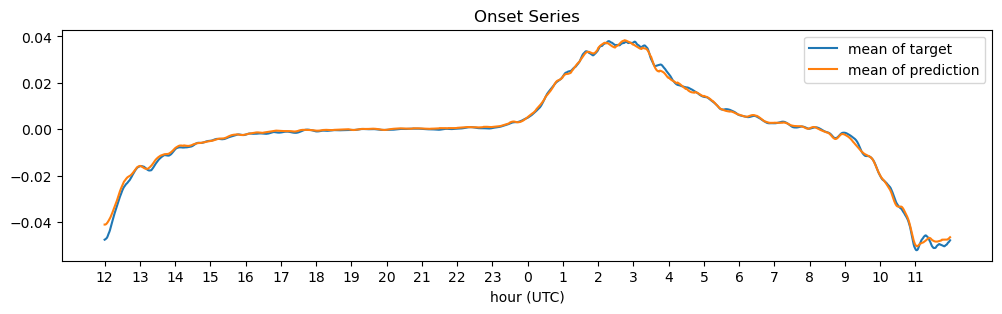

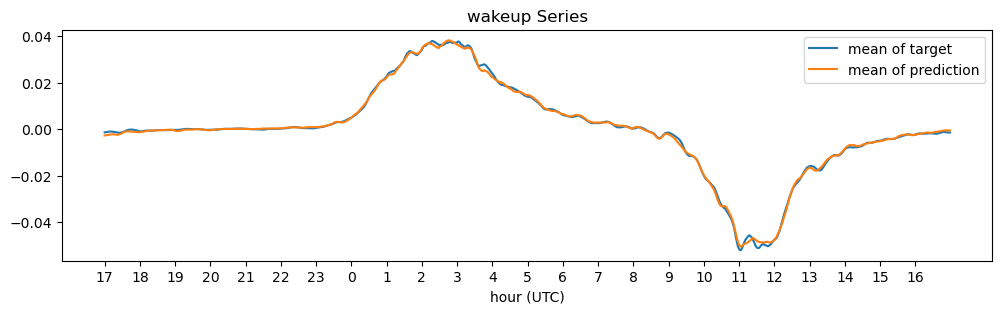

In [12]:
onset_indices = steps.index[steps['kind']=='onset']
plt.figure(figsize=(12, 3))
plt.plot(
    np.arange(24*60),
    ys[onset_indices].mean(axis=0), 
    label="mean of target"
)
plt.plot(
    np.arange(24*60),
    valid_preds[onset_indices].mean(axis=0), 
    label="mean of prediction"
)
plt.xticks(np.arange(0, 24*60, 60), np.concatenate([np.arange(12, 24), np.arange(0, 12)]))
plt.title('Onset Series')
plt.xlabel("hour (UTC)")
plt.legend()
plt.show()

wakeup_indices = steps.index[steps['kind']=='wakeup']
plt.figure(figsize=(12, 3))
plt.plot(
    np.arange(24*60),
    ys[wakeup_indices].mean(axis=0), 
    label="mean of target"
)
plt.plot(
    np.arange(24*60),
    valid_preds[wakeup_indices].mean(axis=0), 
    label="mean of prediction"
)
plt.xticks(np.arange(0, 24*60, 60), np.concatenate([np.arange(17, 24), np.arange(0, 17)]))
plt.title('wakeup Series')
plt.xlabel("hour (UTC)")
plt.legend()
plt.show()

In [13]:
df_preds = np.concatenate([steps.iloc[:, :3].values.repeat(24*60, axis=0), steps.iloc[:, 3:].values.reshape(-1, 1), masks.reshape(-1, 1), ys.reshape(-1, 1), valid_preds.reshape(-1, 1)], axis=1)
df_preds = pd.DataFrame(df_preds, columns=['series_id', 'kind', 'night', 'step', 'mask', 'event', 'score'])
print(df_preds.shape)
display(df_preds.head(5))
display(df_preds.tail(5))

(21473280, 7)


,series_id,kind,night,step,mask,event,score
0,038441c925bb,onset,1,0,0.0,0.0,-0.0
1,038441c925bb,onset,1,0,0.0,0.0,-0.0
2,038441c925bb,onset,1,0,0.0,0.0,-0.0
3,038441c925bb,onset,1,0,0.0,0.0,-0.0
4,038441c925bb,onset,1,0,0.0,0.0,-0.0


,series_id,kind,night,step,mask,event,score
21473275,fe90110788d2,wakeup,35,0,0.0,0.0,0.0
21473276,fe90110788d2,wakeup,35,0,0.0,0.0,0.0
21473277,fe90110788d2,wakeup,35,0,0.0,0.0,0.0
21473278,fe90110788d2,wakeup,35,0,0.0,0.0,0.0
21473279,fe90110788d2,wakeup,35,0,0.0,0.0,0.0


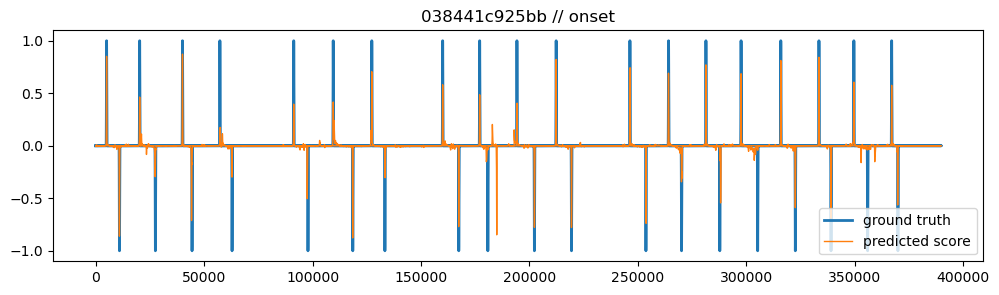

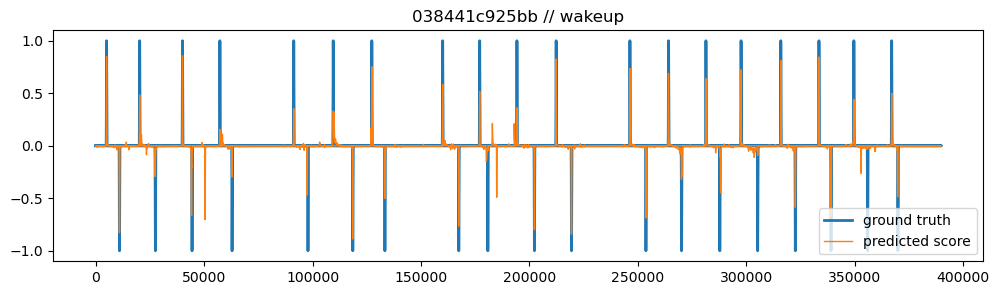

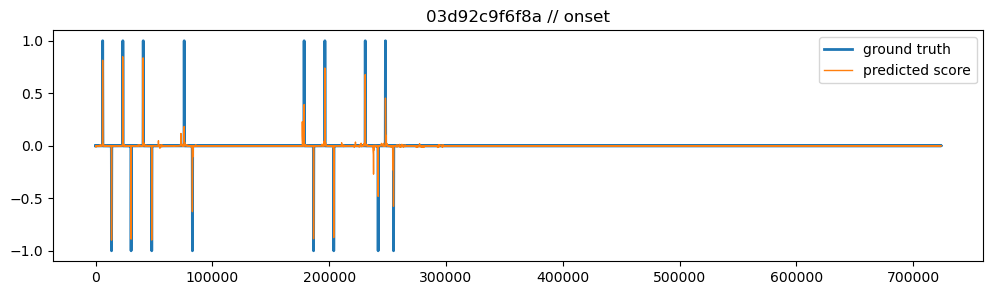

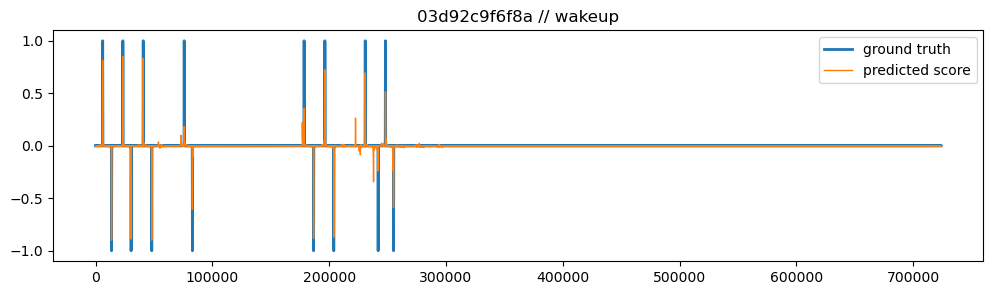

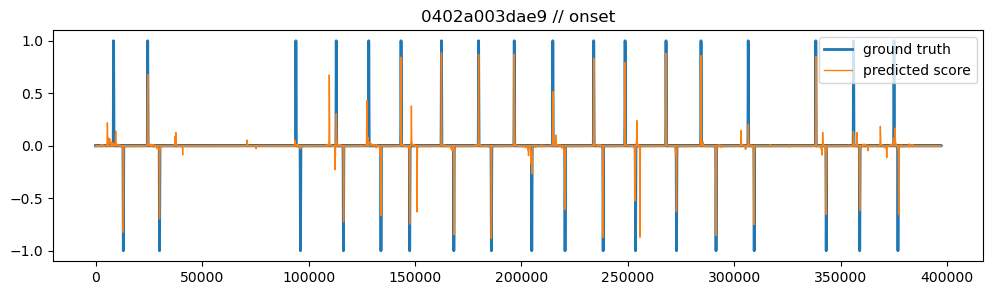

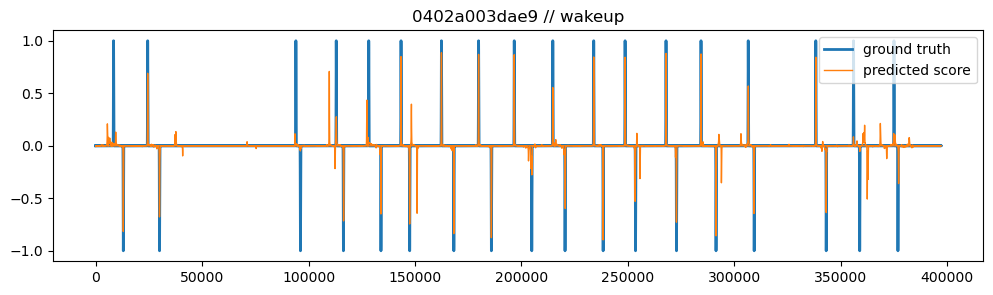

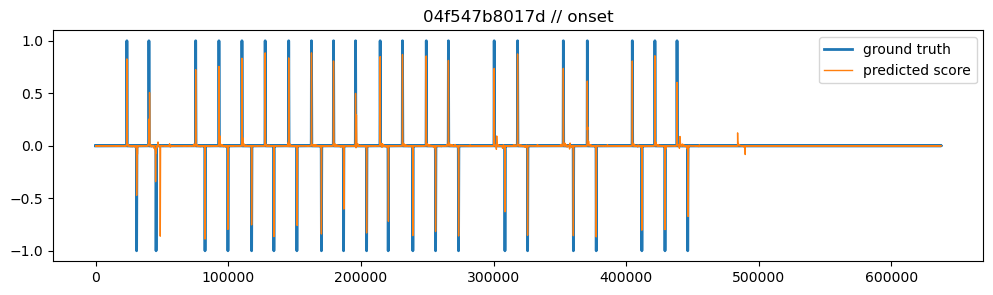

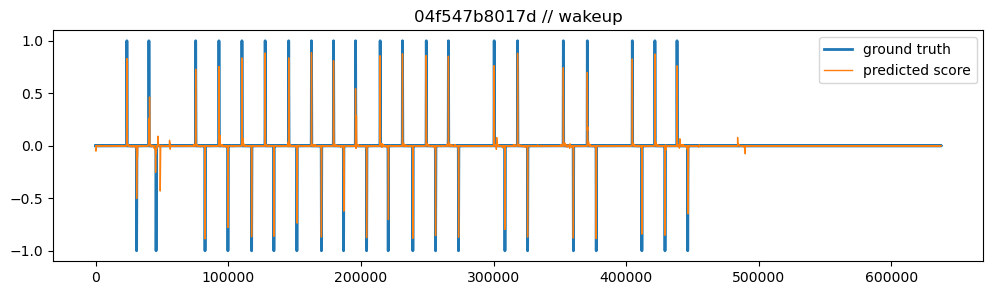

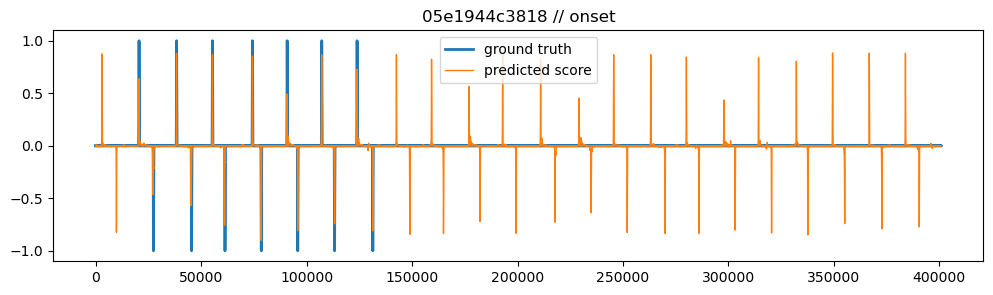

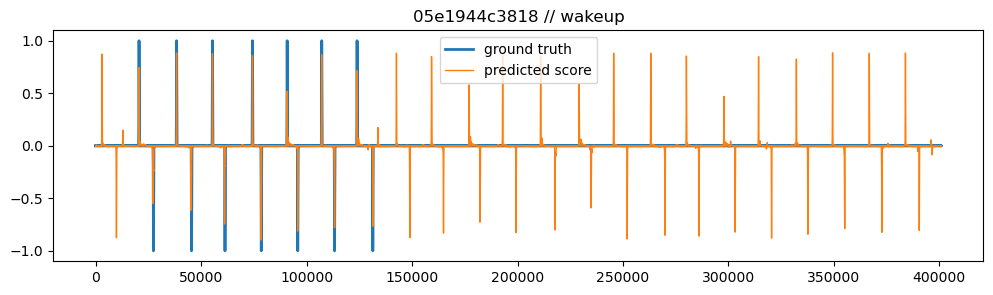

In [14]:
for i, ((series_id, kind), df) in enumerate(df_preds.groupby(['series_id', 'kind'])):
    if i == 10:
        break
    plt.figure(figsize=(12, 3))
    plt.plot(df["step"], df["event"], linewidth=2, label="ground truth")
    plt.plot(df["step"], df["score"], linewidth=1, label="predicted score")
    #plt.plot(df["step"], df["mask"], linewidth=1, label="mask")
    plt.legend()
    plt.title(f'{series_id} // {kind}')
    plt.show()
    plt.close()

# Submission

In [15]:
events = pd.read_csv(INPUT_DIR + 'train_events.csv').dropna()

In [16]:
list_df_peak = []
for (series_id, kind), df in df_preds.groupby(['series_id', 'kind']):
    step_values = df['step'].values
    if kind == 'onset':
        score_values = df['score'].values
    else:
        score_values =  - df['score'].values
    
    peak = find_peaks(score_values, height=0.0, distance=8)
    df_peak = pd.DataFrame(peak[1]['peak_heights'], columns=['score'])
    df_peak['series_id'] = series_id
    df_peak['event'] = kind
    df_peak['step'] = step_values[peak[0]]
    list_df_peak.append(df_peak)

df_sub = pd.concat(list_df_peak)
df_sub = df_sub.sort_values(['series_id', 'step']).reset_index(drop=True)
df_sub = df_sub[["series_id", "step", "event", "score"]].reset_index(names="row_id")

In [17]:
event_detection_ap(
    solution=events[['series_id', 'event', 'step']],
    submission=df_sub
)

0.7757607806546554

In [18]:
pl_df_preds = pl.from_pandas(df_preds)
pl_df_preds = pl_df_preds.group_by(['series_id', 'step']).agg(pl.col('score').mean(), pl.col('event').first()).sort(['series_id', 'step'])
pl_df_preds = pl_df_preds.to_pandas()

C:\Users\DY\AppData\Local\Temp\ipykernel_17796\668657104.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  pl_df_preds = pl_df_preds.groupby(['series_id', 'step']).agg(pl.col('score').mean(), pl.col('event').first()).sort(['series_id', 'step'])


In [19]:
list_df_peak = []
for series_id, df in pl_df_preds.groupby(['series_id']):
    step_values = df['step'].values
    for event in ['onset', 'wakeup']:
        if event == 'onset':
            score_values = df['score'].values
        else:
            score_values =  - df['score'].values
    
        peak = find_peaks(score_values, height=0.0, distance=8)
        df_peak = pd.DataFrame(peak[1]['peak_heights'], columns=['score'])
        df_peak['series_id'] = series_id
        df_peak['event'] = event
        df_peak['step'] = step_values[peak[0]]
        list_df_peak.append(df_peak)

df_sub = pd.concat(list_df_peak)
df_sub = df_sub.sort_values(['series_id', 'step']).reset_index(drop=True)
df_sub = df_sub[["series_id", "step", "event", "score"]].reset_index(names="row_id")

C:\Users\DY\AppData\Local\Temp\ipykernel_17796\3561041080.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for series_id, df in pl_df_preds.groupby(['series_id']):


In [20]:
event_detection_ap(
    solution=events[['series_id', 'event', 'step']],
    submission=df_sub
)

0.7775803110101712